In [ ]:
# Initialize the environment
using Pkg
Pkg.activate(".")
Pkg.instantiate()
ENV["DATADEPS_ALWAYS_ACCEPT"] = true # accept the download of the MNIST dataset
SHOW_PROGRESS_BAR = false # turn off progress bars

# Quantum Reservoir Computing Demo

In this notebook we will show you how to train a model to classify MNIST images using quantum reservoir computing (QRC) in Julia. The general idea is that probing the chaotic dynamics of quantum systems can be used to create a non-linear mapping from a low-dimensional space of features (in our case PCA embeddings extracted from the MNIST images) to a high dimensional space. In order to construct the mapping, we first ensure that extracted features of the data will control the dynamics of the quantum system. Then, we measure observables (in this case, spin expectation values and correlations) over time. These measurements form the output of the mapping.   

Through the embedding in this high dimensional space classification is done through a simple linear postprocessing layer. This circumvents any need for gradient evaluation for quantum dynamics and guarantees trainability. 

This demo provides an emulated QRC that does not require access to a quantum computer. It uses classical, numerical simulations of a quantum system with 8 qubits. The classical simulation makes use of the package [Bloqade.jl](https://github.com/QuEraComputing/Bloqade.jl), which is designed for numerical simulations of neutral-atom architectures.

Neutral atom architectures provide access to several encoding possibilities. In this demo, we map features of the data to the local detuning terms in the Rydberg Hamiltonian.

In [ ]:
# import required libraries
using MLDatasets
using MultivariateStats
using OneHotArrays
using Flux
using Bloqade
using Colors
using ProgressBars
using JLD2
using Plots

The dataset we will be working on is MNIST - a set of 28x28 pixel images of handwritten digits.

In [3]:
# Download the MNIST dataset

# training data set (each image has 28x28 pixels and there are 60000 training samples)
data_train = MNIST(:train)
# test data set (10000 test samples)
data_test = MNIST(:test) 

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

In [4]:
# example of an training dataset image for '5'
Gray.(data_train.features[:, :, 1]')

## PCA Reduction

In this notebook, we train a QRC model using 10000 samples from the MNIST dataset.

As we focus on numerical simulation where the number of atoms in the quantum system is limited, we first perform dimensionality reduction using the [principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) and train on the first 8 PCA components. Note that the performance of any ML model working with 8 components is limited by the amount of input features endcoded. 

In [5]:
# We first use PCA to downsample the data into 8-dimensional vectors
dim_pca = 8

# Use the `fit` function from the `MultivariateStats` package to generate the projection operator for PCA
model_pca = fit(PCA, reshape(data_train.features, (784, 60000)); maxoutdim=dim_pca);

# Use the `predict` function from `MultivariateStats` package to compute the first 8 principal components
x = predict(model_pca, reshape(data_train.features, (784, 60000)))

# Let us see how it looks
num_examples = 10000
xs = x[:, 1:num_examples]

8×10000 Matrix{Float32}:
  0.485965   3.96748   -0.203377    …  -1.89963   -1.48374   -1.45349
 -1.22618   -1.15631    1.53793        -1.36298    1.87735    2.20834
  0.096155  -2.33856    0.739271       -3.06433    1.69584   -2.16987
 -2.1794    -1.80688    2.04323         0.457865  -1.00216   -1.84321
 -0.107124  -3.2443    -1.20274         1.86214    1.05195   -1.40481
 -0.91168   -0.713541  -0.00720511  …  -1.30818   -0.316314   0.778605
 -0.917591   0.17659    3.36885        -0.899219   1.00496   -1.32523
  0.626677  -0.411638   1.44547         1.52077   -0.671548   0.0921289

Here, we scale the range of principal components to a range of local detuning (we use $[-6\ \text{rad}/\mu s,6\ \text{rad}/\mu s]$). And later, for each image, we will encode each of the 8 scaled principal components into each single local detuning for 8 atoms.

In [6]:
Δ_max = 6
spectral = max(abs(maximum(xs)), abs(minimum(xs)))
xs = xs/spectral * Δ_max # to make sure values to be between [-6.0, 6.0]

8×10000 Matrix{Float32}:
  0.319297    2.60678   -0.133627    …  -1.24813   -0.97487   -0.955001
 -0.805644   -0.759736   1.01048        -0.895526   1.23349    1.45096
  0.0631774  -1.53652    0.485729       -2.01338    1.11423   -1.42568
 -1.43195    -1.18719    1.34248         0.300834  -0.658459  -1.21106
 -0.0703842  -2.13162   -0.790247        1.2235     0.69117   -0.923016
 -0.599008   -0.468823  -0.00473403  …  -0.859521  -0.20783    0.511573
 -0.602892    0.116027   2.21346        -0.590821   0.660294  -0.870725
  0.41175    -0.270462   0.949728        0.999202  -0.441233   0.0605322

We are using [one-hot encoding](https://en.wikipedia.org/wiki/One-hot) for the data labels spanning 0 to 9.

In [7]:
y = onehotbatch(data_train.targets, 0:9)
# Let us see how labels look
ys = y[:, 1:num_examples]

10×10000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  1     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅

## Simulate Quantum Dynamics

We can now set up the quantum simulation through following steps:

- Define a `struct`, which captures all physical parameters and readouts of the quantum system.
- Define functions that simulate quantum dynamics with the input `x` from scaled detunings and return the output `out` of readout observables (embeddigs)
- The simulation of the quantum dynamics has been implemented in [Bloqade.jl](https://queracomputing.github.io/Bloqade.jl/dev/)

In [8]:
# Define the struct
Base.@kwdef struct DetuningLayer
    atoms # atom positions
    readouts # readout observables
    Ω::Float64 # Rabi frequency
    t_start::Float64 # evolution starting time
    t_end::Float64 # evolution ending time
    step::Float64  # readout time step
    reg::AbstractArrayReg # quantum state storage
end

DetuningLayer

In [9]:
# Iterate over each single image to simulate the quantum evolution and record the output
# For more details on simulation, please refer to Bloqade.jl and Yao.jl
function apply_layer(layer::DetuningLayer, x::Vector{<:Real})
    # define Rydberg hamiltonian, detunings parameterized in terms of pca values (x)  
    h = rydberg_h(layer.atoms; Δ = x, Ω = layer.Ω) 
    
    # At the start of the simulation, all atoms of the system are in ground states
    reg = layer.reg
    set_zero_state!(reg) 
    
    t_start = layer.t_start
    t_end = layer.t_end
    t_step = layer.step
    
    # initialize output vector
    steps = floor(Int, (t_end - t_start) / t_step)
    out = zeros(steps * length(layer.readouts))
    
    # Numerically simulate the quantum evolution with Krylov methods and store the readouts
    prob =  KrylovEvolution(reg, layer.t_start:layer.step:layer.t_end, h)
    for (step, reg, _) in prob # step through the state at each time step 
        step == 1 && continue # ignore first time step, this is just the initial state
        for (i, op) in enumerate(layer.readouts)
            out[i] = real(expect(op, reg)) # store the expectation of each operator for the given state in the output vector 
        end
    end
    return out
end

# implement functions that apply a `DetuningLayer` to a matrix containing scaled detunings for each image
function apply_layer(layer::DetuningLayer, x::Matrix{<:Real})
    iter = SHOW_PROGRESS_BAR ? ProgressBar(1:size(x, 2)) : 1:size(x, 2)
    outs = [apply_layer(layer, x[:, i][:]) for i in iter]
    return hcat(outs...)
end

apply_layer (generic function with 2 methods)

Now we use the above struct to describe our QRC model. We prepare the 8 atoms in a chain lattice and use a numerical simulation of the quantum dynamics associated to the input.

In [10]:
# Generate atom positions for the toy model
d = 10
atoms = generate_sites(ChainLattice(), dim_pca; scale = d); # put dim_pca atoms in a chain with 10 micron spacing

# create all single site Zᵢ and correlator ZᵢZⱼ readouts 
nsites = length(atoms)
readouts = AbstractBlock[put(nsites, i => Z) for i in 1:nsites]
for i in 1:nsites
    for j in i+1:nsites
        push!(readouts, chain(put(nsites, i => Z), put(nsites, j => Z)))
    end
end

# build preprocessing layer - we decide to run the dynamics for 4 microseconds, sampling every 0.5 microseconds
pre_layer = DetuningLayer(;
    atoms, 
    readouts, 
    Ω = 2π, 
    t_start = 0.0, 
    t_end = 4.0, 
    step = 0.5, 
    reg = zero_state(nsites)
);

Now, we are ready to run the simulation by applying the defined `pre_layer` to the scaled detunings! For each image, the readouts from the quantum dynamics form a 440-dimensional vector. The full results will be stored in a $440\times 1000$ matrix `embeddings`.

(It might take a few minutes)

In [11]:
# uncomment the next line to see progress bar (not recommended)
# SHOW_PROGRESS_BAR = true 
embeddings = apply_layer(pre_layer, xs)

288×10000 Matrix{Float64}:
 -0.133399     0.151747    0.350163   …  -0.0834522   0.449993    0.549537
  0.245094     0.209978    0.397272       0.0459972   0.290492    0.371386
 -0.182834     0.063805    0.215855      -0.112712    0.26677    -0.102801
 -0.166935     0.350495    0.104194       0.0914767  -0.208227   -0.285811
 -0.148817    -0.128978   -0.301915      -0.0235604  -0.0205817   0.119332
 -0.202002     0.183756   -0.220745   …  -0.180546    0.0503745  -0.0974302
  0.129653     0.444773    0.248125      -0.101945    0.347082    0.143508
 -0.0487518    0.226272   -0.0753717      0.0769758   0.399699    0.00870852
 -0.193198    -0.220791    0.0482392     -0.0746711   0.0645135   0.119173
  0.176448    -0.0183643   0.114046       0.033879    0.23169    -0.0942763
  0.00447608   0.0406091   0.0920517  …  -0.0533521  -0.182036   -0.225216
  0.108352     0.130001   -0.076437       0.0013166  -0.0229793   0.115064
 -0.0282972    0.153062   -0.13803       -0.0246751   0.0300192  -0.0

## Training

Now we are going to train a classical neural network without hidden layers (a linear classifier with `softmax` output function), using quantum measurements stored in `embeddings` as the input. In comparision, we also trained a linear classifier directly using PCA feature vectors without the quantum reservoir processing as well as 4-layer neural network.

Here, we used the machine learning framework [Flux.jl](https://fluxml.ai/Flux.jl/stable/) in Julia for the neural network training.

First, we define the function `train` for training.

In [12]:
#We define a function to evaluate the accuracy by camparing the predicting result and the label.
accuracy(model, xs, targets) = sum(onecold(model(xs), 0:9) .== targets)/length(targets)

#the function takes training and test features and labels as well as training hyperparameters as inputs
function train(xs_train, ys_train, xs_test, ys_test; 
    regularization::Float64 = 0.0, nepochs::Int = 100, batchsize::Int = 100, 
    opt = Flux.Adam(0.01), verbose::Bool, nonlinear::Bool=false)
    
    #linear regression layer
    model = Chain( 
    Dense(length(xs_train[:, 1]), 10),
    softmax
    )

    #4-layer neural network for comparison with QRC
    if nonlinear
        model = Chain(
            Dense(length(xs_train[:, 1]), 100, relu),
            Dense(100, 100, relu),
            Dense(100, 10),
            softmax
        )
    end

    loader = Flux.DataLoader((data = xs_train, label = ys_train); batchsize, shuffle=true);
    ps = Flux.params(model)

    verbose && println("Training...")
    losses = zeros(nepochs)
    accs_train = zeros(nepochs)
    accs_test = zeros(nepochs)
    for epoch in (verbose ? ProgressBar(1:nepochs) : 1:nepochs)
    l = 1.0
    for (x, y) in loader
        grads = Flux.gradient(ps) do
            ŷ = model(x) 
            if iszero(regularization)
                l = Flux.crossentropy(ŷ, y) 
            else
                l = Flux.crossentropy(ŷ, y) + regularization * sum(sum(abs, p) for p in ps)
            end
        end
        Flux.update!(opt, ps, grads)
    end
    losses[epoch] = Flux.crossentropy(model(xs_train), ys_train)
    accs_train[epoch] = accuracy(model, xs_train, onecold(ys_train, 0:9))
    accs_test[epoch] = accuracy(model, xs_test, ys_test)
    end
    return losses, accs_train, accs_test
end

train (generic function with 1 method)

## Model evaluation and prediction
We will also process the test set with the same QRC embeddings.

We use 1000 samples from the test set for evaluation.

In [13]:
num_test_examples = 1000

# using the same PCA model we fit to the test set
test_features = predict(model_pca, reshape(data_test.features, (784, 10000)))[:, 1:num_test_examples] 

# same rescaling we applied on train input get reasonable detuning values 
test_features_qrc = test_features/spectral * Δ_max 

# correct labels for the test samples
test_targets = data_test.targets[1:num_test_examples]

# quantum embeddings for the test samples
test_embeddings = apply_layer(pre_layer, test_features_qrc)

288×1000 Matrix{Float64}:
  0.306896     0.329629    0.228583     …  -0.0710129   0.272995
  0.275329     0.0490653  -0.0518663        0.121653    0.374146
  0.188873    -0.177173   -0.0964597       -0.143538    0.351746
 -0.265484     0.0458983  -0.133806        -0.0113999   0.310199
 -0.0953729    0.311374   -0.414197        -0.0417693   0.216794
 -0.251902    -0.109166   -0.000511877  …  -0.315698    0.0202466
 -0.0027376    0.0407177   0.151372        -0.144355    0.00306887
 -0.0782181   -0.106569    0.0890856        0.0169558   0.19174
 -0.00266637  -0.0419958  -0.0174768       -0.0879273   0.107122
  0.125312    -0.0525786   0.00936087       0.194055    0.301402
 -0.178978     0.033029    0.0244329    …  -0.0580568   0.0450005
 -0.146322     0.0925839  -0.158386         0.0499389   0.0985447
 -0.0921002   -0.0706393  -0.0330158        0.0648992  -0.042588
  ⋮                                     ⋱              
  0.0          0.0         0.0              0.0         0.0
  0.0    

To get a baseline, we first train a linear clasifier using PCA components directly as data features. The QRC has to outperform this baseline to be a viable embedding.

In [14]:
loss_lin, accs_train_lin, accs_test_lin= train(xs, ys, test_features, test_targets;
 regularization= 0.0005, nepochs= 100, batchsize= 1000, opt = Flux.Adam(0.01), verbose=false, nonlinear=false)

([2.3520781993865967, 1.9699336290359497, 1.6712144613265991, 1.4462196826934814, 1.2821862697601318, 1.1644724607467651, 1.0790616273880005, 1.015565037727356, 0.9671584963798523, 0.9288636445999146  …  0.6452295184135437, 0.6449748277664185, 0.6447712779045105, 0.6445609331130981, 0.6443562507629395, 0.6441338658332825, 0.6439461708068848, 0.6437873840332031, 0.6435766816139221, 0.6433976292610168], [0.179, 0.3148, 0.4349, 0.5455, 0.6208, 0.6695, 0.6986, 0.7172, 0.727, 0.7346  …  0.7913, 0.7914, 0.7917, 0.7915, 0.7916, 0.7922, 0.7918, 0.7916, 0.792, 0.7921], [0.219, 0.369, 0.466, 0.54, 0.586, 0.626, 0.655, 0.671, 0.683, 0.684  …  0.737, 0.738, 0.736, 0.738, 0.738, 0.738, 0.739, 0.739, 0.739, 0.738])

PCA+linear layer test accuracy=73.8%


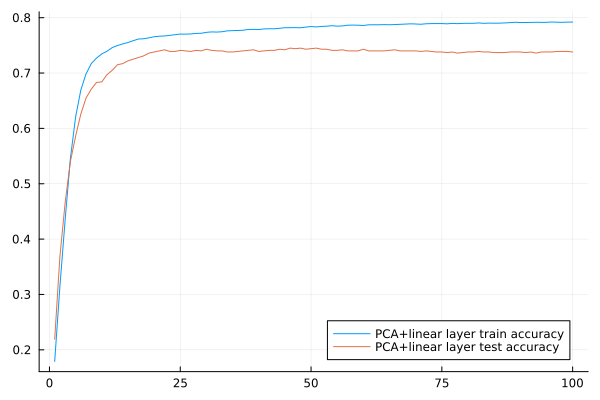

In [15]:
println("PCA+linear layer test accuracy=", accs_test_lin[end]*100, "%")
Plots.plot(accs_train_lin, label="PCA+linear layer train accuracy")
Plots.plot!(accs_test_lin, label="PCA+linear layer test accuracy")

Now, we use our QRC embeddings to train the same linear regression layer!

In [16]:
loss_qrc, accs_train_qrc, accs_test_qrc= train(embeddings, ys, test_embeddings, test_targets;
regularization= 0.00005, nepochs= 100, batchsize= 1000, opt = Flux.Adam(0.01), verbose=false, nonlinear=false)

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(288 => 10)    # 2_890 parameters
│   summary(x) = "288×1000 Matrix{Float64}"
└ @ Flux ~/.julia/packages/Flux/CUn7U/src/layers/stateless.jl:60


([2.160031318664551, 2.0337448120117188, 1.9257668256759644, 1.8329062461853027, 1.7519972324371338, 1.6818277835845947, 1.6199222803115845, 1.5652461051940918, 1.516958236694336, 1.4739636182785034  …  0.8868886828422546, 0.885667085647583, 0.8844265341758728, 0.8832235336303711, 0.882101833820343, 0.8809347748756409, 0.8798564672470093, 0.8787281513214111, 0.8777944445610046, 0.8766975402832031], [0.4096, 0.4494, 0.4949, 0.5293, 0.5491, 0.5677, 0.5818, 0.5924, 0.6018, 0.6093  …  0.7239, 0.7234, 0.7239, 0.7245, 0.7248, 0.724, 0.724, 0.7245, 0.7243, 0.7246], [0.406, 0.455, 0.5, 0.537, 0.549, 0.564, 0.575, 0.573, 0.585, 0.588  …  0.702, 0.701, 0.699, 0.699, 0.698, 0.702, 0.702, 0.696, 0.701, 0.698])

QRC test accuracy=69.8%


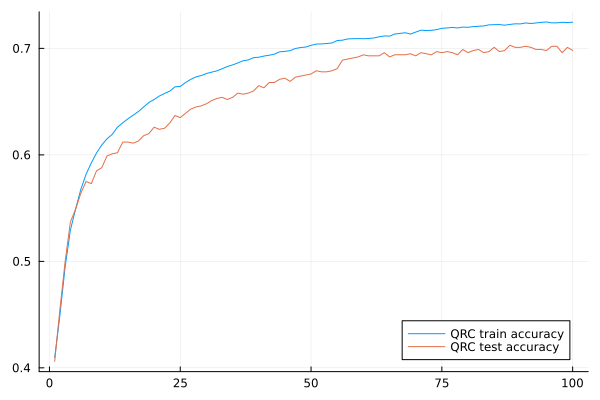

In [17]:
println("QRC test accuracy=", accs_test_qrc[end]*100, "%")
Plots.plot(accs_train_qrc, label="QRC train accuracy")
Plots.plot!(accs_test_qrc, label="QRC test accuracy")

Around 86% accuracy with QRC is achieved with 8 PCA components. There is a clear benefit of the embedding as compared to linear layer.

But how does QRC on 8 PCA components compare to the classical neural network? To extract all the performance from 8 PCA's, a simple 4-layer network sufices.

In [18]:
loss_nn, accs_train_nn, accs_test_nn= train(xs, ys, test_features, test_targets;
regularization= 0.0002, nepochs= 100, batchsize= 1000, opt = Flux.Adam(0.01), verbose=false, nonlinear=true) #nonlinear=true switches to the 4-layer NN for training

([0.6243657469749451, 0.5035727024078369, 0.42502227425575256, 0.3956921696662903, 0.37192267179489136, 0.3447299301624298, 0.33533868193626404, 0.33688977360725403, 0.3257392644882202, 0.31738317012786865  …  0.19824042916297913, 0.1904488354921341, 0.18911212682724, 0.1920999437570572, 0.19502775371074677, 0.1985107958316803, 0.1974892020225525, 0.19234009087085724, 0.19117017090320587, 0.18754829466342926], [0.7911, 0.8344, 0.8586, 0.8628, 0.8729, 0.885, 0.8894, 0.8859, 0.8912, 0.8939  …  0.9318, 0.9362, 0.9352, 0.9357, 0.9356, 0.9337, 0.9327, 0.9328, 0.9338, 0.9385], [0.767, 0.81, 0.824, 0.832, 0.84, 0.849, 0.861, 0.851, 0.858, 0.859  …  0.859, 0.864, 0.866, 0.853, 0.861, 0.864, 0.863, 0.861, 0.857, 0.86])

PCA+NN test accuracy=86.0%


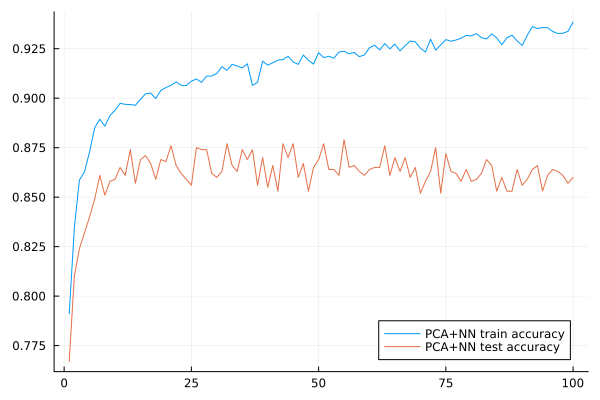

In [19]:
println("PCA+NN test accuracy=", accs_test_nn[end]*100, "%")
Plots.plot(accs_train_nn, label="PCA+NN train accuracy")
Plots.plot!(accs_test_nn, label="PCA+NN test accuracy")

The performance of the QRC matches that of neural network on 8 PCA components. QRC is performing as well as possible on the downsampled MNIST dataset! However, simulations quickly become expensive and evaluating QRC performance without such heavy downsampling can only be done on quantum hardware.


### Explorations

1. How does the QRC perform if we only collect <Z_i> expectation values and drop <Z_i Z_j> correlations? Why do you think this happens?

Hint: Try to modify the readouts vector to exclude correlations.

2. What happens if atoms are further apart, like 15 micrometers? What does it tell us about the role of interactions for QRC performance? 

What if they are very close (4 micrometers apart, for example) - the evaluation will take longer for these parameters, but what is your guess?